# Ensemble Learning

Ensemble learning is an algorithm in which we take predictions of a group of predictors, then predict the class that gets most votes.
A group of predictos is called an ensemble.


In [23]:
import sys
assert sys.version_info >= (3,5) #python >= 3.5 required

import sklearn
assert sklearn.__version__ >= "0.20" #sklearn >= 0.20 required

In [24]:
import numpy as np 
import os

In [25]:
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout() #automatically adjust subplots parameters to give specified padding.
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Voting Classifier

In majority voting we create an ensemble of different , train them on trainig sets , then the most predicted class will be taken.

This majority voting classifier is known as hard voting classifier.


### Law of large Numbers

Suppose you have a slightly biased coin that has a 51% chance of coming up heads, and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%).

In [26]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cummulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1,10001).reshape(-1,1)

Saving figure law_of_large_numbers_plot


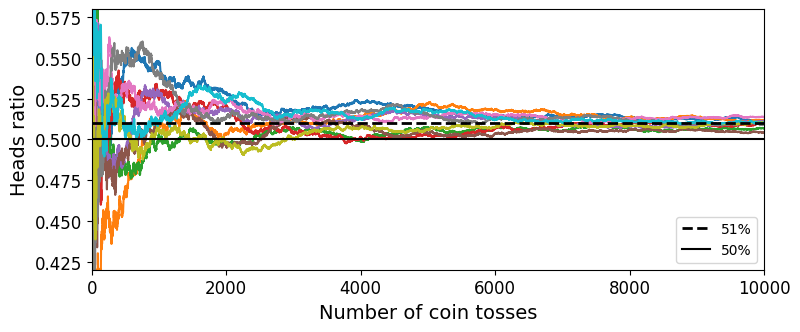

In [62]:
plt.figure(figsize=(8,3.5))
plt.plot(cummulative_heads_ratio)
plt.plot([0,10000], [0.51,0.51], "k--", linewidth=2, label="51%")
plt.plot([0,10000], [0.5,0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0,10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

### hard voting classifier

In [28]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

make_moons

<function sklearn.datasets._samples_generator.make_moons(n_samples=100, *, shuffle=True, noise=None, random_state=None)>

In [29]:
X, y = make_moons(n_samples=1000,shuffle=True, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#we will ensemble 3 classifiers (logistic regression, random forest, svc)
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('rd', forest_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rd', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [33]:
#look at each classifiers accuracy
from sklearn.metrics import accuracy_score

for clf in (log_reg, svm_clf, forest_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8545454545454545
SVC 0.9090909090909091
RandomForestClassifier 0.9181818181818182
VotingClassifier 0.9121212121212121


### Soft voting classifier

If all the classifiers are able to predict class probabilities(i.e; they have a `predict_proba()` method) then you can tell scikit-learn to predict class with the highest class probability, averaged over all individual classifiers. This is called soft voting.
It ofter achieves higher performance than hard voting because it gives more weight to highly confident votes. (replace voting="hard" with voting="soft")

In [37]:
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale",probability=True, random_state=42)

voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_reg),('svc', svm_clf), ('rd', forest_clf)], #svc is not used because it do not have attribute predict proba
    voting='soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rd', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [38]:
for clf in (log_reg,svm_clf, forest_clf, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8545454545454545
SVC 0.9090909090909091
RandomForestClassifier 0.9181818181818182
VotingClassifier 0.9151515151515152


## Bagging and Pasting

Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. When sampling is performed with replacement, this method is called bagging (short for
bootstrap aggregating). When sampling is performed without replacement, it is called pasting.

The following code trains an ensemble of 500 Decision Tree classifiers each trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False).

The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores):

In [41]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier(
    tree_clf, n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True, random_state=42
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=42)

In [43]:
bag_clf.oob_score_ #gives to out_of_bag evaluation of the classifier

0.9194029850746268

In [44]:
bag_clf.oob_decision_function_ #gives the out_of_bag (oob) evaluation for each clf

array([[0.35083532, 0.64916468],
       [0.0547619 , 0.9452381 ],
       [0.02078522, 0.97921478],
       ...,
       [0.95933014, 0.04066986],
       [0.71764706, 0.28235294],
       [0.06744186, 0.93255814]])

In [45]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_pred , y_test)

0.9030303030303031

In [46]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_pred_tree, y_test)

0.8878787878787879

In [50]:
#code to draw plot of decision tree clf and decision tree with bagging
from matplotlib.colors import ListedColormap

def plot_desision_boundary(clf, X,y, axes=[-1.5,2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1,x2,y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1,x2,y_pred, cmap=custom_cmap2, aplha=0.8)

    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:,0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

/tmp/ipykernel_6857/3075447390.py:13: UserWarning: The following kwargs were not used by contour: 'aplha'
  plt.contour(x1,x2,y_pred, cmap=custom_cmap2, aplha=0.8)
/tmp/ipykernel_6857/3075447390.py:13: UserWarning: The following kwargs were not used by contour: 'aplha'
  plt.contour(x1,x2,y_pred, cmap=custom_cmap2, aplha=0.8)


Saving figure decision_tree_without_and_with_bagging


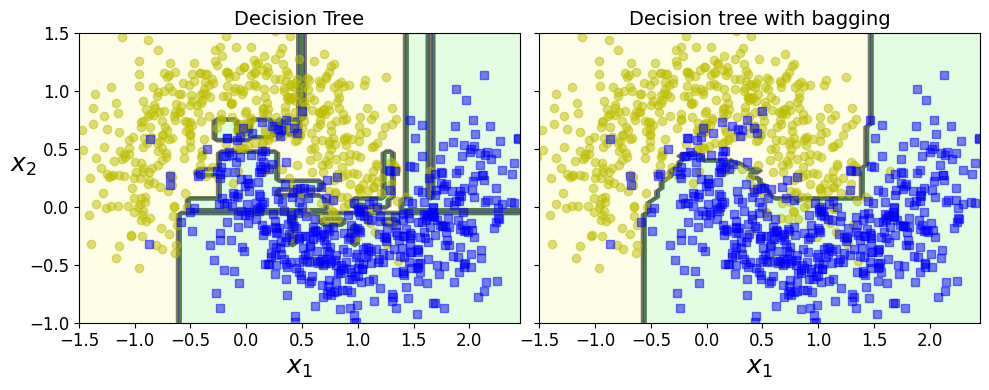

In [51]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_desision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_desision_boundary(bag_clf, X, y)
plt.title("Decision tree with bagging", fontsize=14)

plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging")
plt.show()


## Random Forests

In [52]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [54]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [55]:
np.sum(y_pred == y_pred_rf) / len(y_pred) #very similar predictions

1.0

## Extra Trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds. A forest of such extremely random trees is simply called an Extremely Randomized Trees ensemble (or Extra trees).

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
ext_clf.fit(X_train, y_train)
ext_pred = ext_clf.predict(X_test)
accuracy_score(ext_pred, y_test)

0.996969696969697

## Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest).



In [56]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name , score)

sepal length (cm) 0.09286467091625845
sepal width (cm) 0.02087553463986756
petal length (cm) 0.44591247340199563
petal width (cm) 0.4403473210418783


It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively).

In [57]:
rnd_clf.feature_importances_

array([0.09286467, 0.02087553, 0.44591247, 0.44034732])

The following figure overlays the decision boundaries of 15 decision trees. As you can see, even though each decision tree is imperfect, the ensemble defines a pretty good decision boundary:

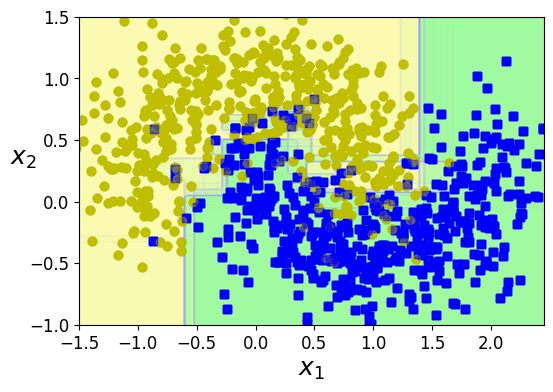

In [61]:
plt.figure(figsize=(6,4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42+i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_desision_boundary(tree_clf, X, y, axes=[-1.5,2.45, -1, 1.5], alpha=0.2, contour=False)

plt.show()